# Dataset Exploration

In [1]:
import os 
#make sure your working directory is the repository root. 
if not os.getcwd().endswith("idp-radio-1"):
    os.chdir("../../")
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import math
from src.preprocessing.rescaling import scaler

In [2]:
load_dotenv(find_dotenv())

True

## Data Loading

In [3]:
chexpert_folder = Path(os.environ.get("CHEXPERT_DATASET_DIRECTORY"))

train_labels = pd.read_csv(chexpert_folder / "train.csv")
valid_labels = pd.read_csv(chexpert_folder / "valid.csv")
train_labels.head()

,Unnamed: 0,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient_id
0,52,CheXpert-v1.0-small/train/patient00019/study1/...,Female,46,Frontal,PA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,19
1,53,CheXpert-v1.0-small/train/patient00019/study1/...,Female,46,Lateral,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,19
2,54,CheXpert-v1.0-small/train/patient00019/study4/...,Female,50,Frontal,AP,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,0.0,19
3,55,CheXpert-v1.0-small/train/patient00019/study3/...,Female,46,Frontal,AP,NaN,1.0,NaN,NaN,...,NaN,1.0,NaN,1.0,0.0,1.0,NaN,NaN,NaN,19
4,56,CheXpert-v1.0-small/train/patient00019/study2/...,Female,46,Frontal,AP,NaN,NaN,NaN,1.0,...,NaN,-1.0,NaN,-1.0,0.0,NaN,NaN,NaN,0.0,19


First, we have a simple look at the pictures in the dataset. There are two kinds of views, lateral
and frontal. 

### Shape of dataset

In [4]:
print('Shape of train data:', train_labels.shape)

Shape of train data: (15614, 21)


#### Patients

In [5]:
print('Number of unique patients:', train_labels.patient_id.unique().shape)
print('Avg. number of images per patient:',  train_labels.shape[0]  / train_labels.patient_id.unique().shape[0])

Number of unique patients: (4480,)
Avg. number of images per patient: 3.485267857142857


#### Studies per patient

In [6]:
counts = train_labels.patient_id.value_counts()
count_df = pd.DataFrame()
count_df['id'] = counts.index
count_df['count'] = counts.to_list()
print('Nr. of Studies | Patients')
print(count_df['count'].value_counts())

Nr. of Studies | Patients
1     1577
2     1191
3      475
4      336
5      217
6      153
7      100
8       71
9       56
10      52
11      38
12      31
14      24
13      22
15      21
16      17
18      17
17      12
19       9
22       6
23       6
21       5
20       5
26       5
24       3
25       3
35       3
28       3
39       2
34       2
27       2
41       2
49       2
36       2
32       1
51       1
48       1
64       1
80       1
92       1
33       1
43       1
38       1
37       1
Name: count, dtype: int64


#### Frontal vs. Lateral

In [7]:
print('Number of Frontal/Lateral images')
train_labels['Frontal/Lateral'].value_counts()

Number of Frontal/Lateral images


Frontal    13371
Lateral     2243
Name: Frontal/Lateral, dtype: int64

## Labels

In [8]:
labels = train_labels.columns.to_list()[6:20]
print(labels)

['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


In [9]:
d = {'Pathology': [], 'Positive': [], 'Positive %': [], 'Uncertain': [], 'Uncertain %': [], 'Negative': [], 'Negative %': [],}
for label in labels:
    values = train_labels.groupby(label)
    d['Pathology'].append(label)

    positive = values.size()[1.0] if 1.0 in values.size() else 0
    positive_percent = positive / train_labels.shape[0] * 100
    d['Positive'].append(positive)
    d['Positive %'].append(round(positive_percent))

    uncertain = values.size()[-1.0] if -1.0 in values.size() else 0
    uncertain_percent = uncertain / train_labels.shape[0] * 100
    d['Uncertain'].append(uncertain)
    d['Uncertain %'].append(round(uncertain_percent))

    negative = values.size()[-0.0] if -0.0 in values.size() else 0
    negative_percent = negative / train_labels.shape[0] * 100
    d['Negative'].append(negative)
    d['Negative %'].append(round(negative_percent))


In [10]:
df = pd.DataFrame(d)
df = df.set_index('Pathology')
df 

,Positive,Positive %,Uncertain,Uncertain %,Negative,Negative %
Pathology,,,,,,
No Finding,1501,10.0,0,0.0,0,0.0
Enlarged Cardiomediastinum,810,5.0,900,6.0,1441,9.0
Cardiomegaly,2065,13.0,549,4.0,768,5.0
Lung Opacity,7568,48.0,335,2.0,480,3.0
Lung Lesion,676,4.0,96,1.0,115,1.0
Edema,3697,24.0,949,6.0,1424,9.0
Consolidation,1028,7.0,1903,12.0,1948,12.0
Pneumonia,455,3.0,1354,9.0,197,1.0
Atelectasis,2397,15.0,2305,15.0,86,1.0


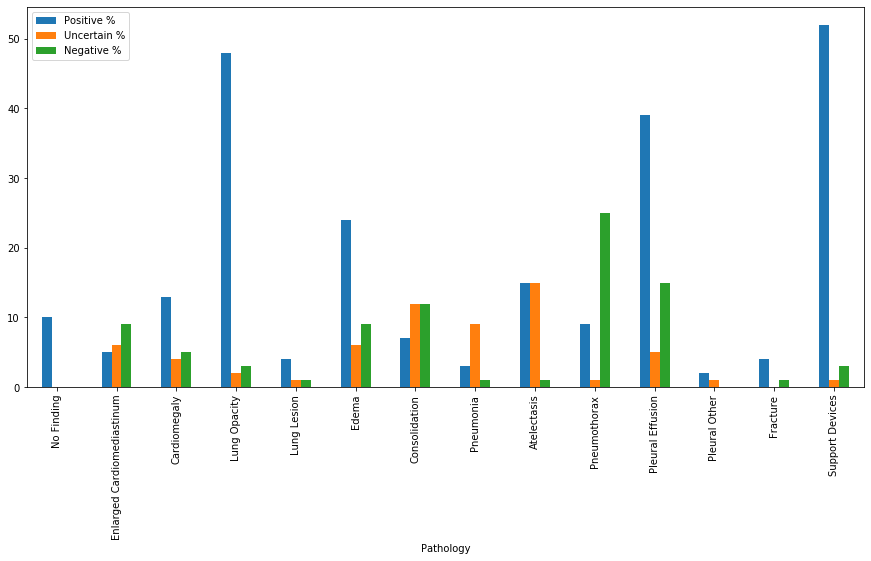

In [11]:
df[['Positive %', 'Uncertain %', 'Negative %']].copy().plot(kind='bar', figsize=(15,7))

In addition to the labels, we have patient-related features and picture metadata in the dataset.

In [12]:
column_names = np.array(train_labels.columns)
print('Patient Information: ', column_names[2:4])
print('Metadata: ', column_names[4:6])

Patient Information:  ['Sex' 'Age']
Metadata:  ['Frontal/Lateral' 'AP/PA']


## Images

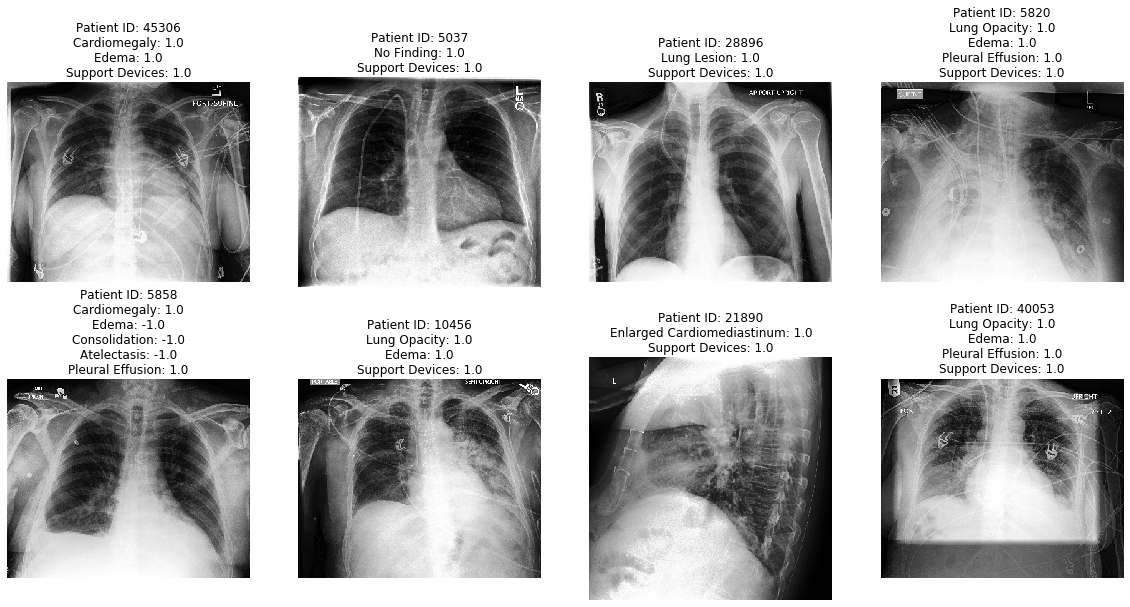

In [13]:
# Randomly sample 8 images
imgs = train_labels['Path'].to_numpy()
imgs_samples = train_labels.sample(n=8, random_state=1)

# Plot random sample of 8 images
plt.figure(figsize=(20, 10))
for i in range(len(imgs_samples)):
    img = cv2.imread(str(chexpert_folder / imgs_samples.Path.to_list()[i]))

    title = "Patient ID: " + str(imgs_samples['patient_id'].to_list()[i])
    for label in labels:
        label_value = imgs_samples[label].to_list()[i]
        if label_value != 0.0 and not math.isnan(label_value):
            title += '\n' + label + ': ' + str(imgs_samples[label].to_list()[i])
    # Plot the image
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
plt.show()


The pictures in the dataset are of varying size, so we take a look at the dimensions of the images. This information needs to be
considered when preprocessing the dataset.

In [14]:
# Prints all the different dimensions that images have
frontal_dimensions = []
lateral_dimensions = []
for index, row in train_labels.iterrows():
    image = cv2.imread(str(chexpert_folder / row['Path']))
    if row['Frontal/Lateral'] == 'Frontal':
        frontal_dimensions.append((image.shape[0], image.shape[1]))
    else:
        lateral_dimensions.append((image.shape[0], image.shape[1]))

In [15]:
frontal = pd.Series(frontal_dimensions)
frontal.value_counts()

(320, 390)    9441
(320, 389)    1518
(320, 320)     926
(320, 369)     247
(320, 371)     138
              ... 
(320, 425)       1
(320, 565)       1
(320, 407)       1
(320, 476)       1
(389, 320)       1
Length: 132, dtype: int64

In [16]:
lateral = pd.Series(lateral_dimensions)
lateral.value_counts()

(320, 320)    612
(390, 320)    363
(369, 320)    363
(371, 320)    154
(368, 320)     52
             ... 
(445, 320)      1
(320, 352)      1
(429, 320)      1
(320, 335)      1
(415, 320)      1
Length: 158, dtype: int64